In [50]:
import numpy as np
from matplotlib import pyplot as plt
import random
from tqdm.auto import tqdm
from time import time

In [51]:
def random_solution(data,i:int):
    path = []
    value = 0
    limit = len(data) // 2
    cur, cost = data[i][:-1], data[i][-1]
    while(len(data) > limit):
        path.append(np.append(cur, cost))
        data = np.delete(data, i, 0)
        i = random.randint(0, len(data)-1)
        value += round(np.linalg.norm(cur-data[i][:-1])) + data[i][-1]
        cur, cost = data[i][:-1], data[i][-1]
        
    value += round(np.linalg.norm(path[0][:-1]-cur)) + path[0][-1]
    path.append(path[0])
    return value, path

In [52]:
def nearest_neighbor(data,i: int):
    path = []
    value = 0
    limit = len(data) // 2
    cur, cost = data[i][:-1], data[i][-1]
    while(len(data) > limit):
        path.append(np.append(cur, cost))
        data = np.delete(data, i, 0)
        costs = np.apply_along_axis(lambda node: round(np.linalg.norm(cur-node[:-1])) + node[-1], 1, data)
        i = np.argmin(costs)
        value += costs[i]
        cur, cost = data[i][:-1], data[i][-1]
        
    value += round(np.linalg.norm(path[0][:-1]-cur)) + path[0][-1]
    path.append(path[0])
    return value, path

In [53]:
from scipy.spatial.distance import cdist

In [54]:
def calculate_average(*args,**kwargs):
    return np.mean(args)

In [55]:
def calculate_cost(data: np.ndarray) -> np.ndarray:
    costs = cdist(data[:,2].reshape(-1,1), data[:,2].reshape(-1,1),calculate_average)
    distances = np.round(cdist(data[:,:2], data[:,:2], 'euclidean'))
    distances = distances + costs
    return distances

In [56]:
def greedy_cycle(data,node_index:int):
    distances = calculate_cost(data)
    visited,edges = [],[]
    limit = len(data) // 2
    # node_index = random.randint(0, len(data)-1)
    cost = data[node_index][-1]
    value = cost
    edges.append([node_index,node_index])
    visited.append(node_index)
    while(len(visited) < limit):
        costs = []
        for edge in edges:
            temp = distances[edge].sum(axis=0)
            temp[visited] = np.inf
            temp-=distances[edge[0],edge[1]]
            costs.append([temp.min() ,temp.argmin()])
        costs = np.array(costs)
        best_new_node_index = costs[:,0].argmin()
        cost,new_node_index = costs[best_new_node_index]
        value+=cost
        visited.append(int(new_node_index))
        parent_nodes = edges.pop(best_new_node_index)
        edges += [[parent_nodes[0],int(new_node_index)],[parent_nodes[1],int(new_node_index)]]
    edges = sort_edges(edges=edges)

    path = data[np.array(edges).flatten()]
    return value, path

In [57]:
def get_match_node(edge1: list, edge2: list) -> list:
    intersection = set(edge1).intersection(set( edge2))
    return list(intersection)

In [58]:
def sort_edges(edges: list) -> list:
    edges_sorted = [edges.pop(0)]
    last_edge = edges_sorted[-1]
    number_of_edges = len(edges)
    while len(edges_sorted) != number_of_edges:
        index = 0
        while len(edges) > index:
            matching_node = get_match_node(last_edge, edges[index])
            if matching_node:
                matching_node = matching_node[0]
                last_edge = last_edge if matching_node == last_edge[1] else last_edge[::-1]
                edge = edges.pop(index)
                edge = edge if last_edge[1] == edge[0] else edge[::-1]
                edges_sorted[-1] = last_edge
                edges_sorted.append(edge)
                last_edge = edges_sorted[-1]
                break
            index+=1
    edges_sorted.append(edges.pop(0))
    return edges_sorted

In [59]:
data = np.loadtxt('TSPA.csv', dtype=int, delimiter=';')

In [60]:
def evaluate(func, data, n=200):
    total, worst_value, best_value, best_solution = 0, 0, float('inf'), None
    total_time, worst_time, best_time = 0,0,float('inf')
    for node_index in tqdm(range(n)):
        start = time()
        value, solution = func(data,node_index)
        elapsed = time() - start
        total_time += elapsed
        if elapsed < best_time:
            best_time = elapsed
        worst_time = max(worst_time, elapsed)


        total += value
        if value < best_value:
            best_solution = solution
            best_value = value
        worst_value = max(worst_value, value)

    return dict(average_score=total / n,
                worst_score=worst_value,
                best_score=best_value,
                solution=np.array(best_solution).T,
                average_time=total_time / n,
                worst_time= worst_time,
                best_time = best_time)

In [61]:
def summarize(func, data, title):
    evaluation_results = evaluate(func, data)
    (x, y, z) = evaluation_results["solution"]
    print(f'{title}:')
    print(f'average time: {evaluation_results["average_time"]}\tworst time: {evaluation_results["worst_time"]}\tbest time: {evaluation_results["best_time"]}')

    print(f'average score: {evaluation_results["average_score"]}\tworst score: {evaluation_results["worst_score"]}\tbest score: {evaluation_results["best_score"]}')
    print('Best solution:')

    plt.figure(figsize=(15,10))
    plt.scatter(x, y, np.full(x.size, 100), z, cmap='gray_r')
    plt.clim(0, 2000)
    plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
    plt.plot(x, y, 'r')
    plt.xlim([-100, 4100])
    plt.ylim([-100, 2100])
    plt.title(title)
    plt.show()

In [62]:
data = np.loadtxt('TSPA.csv', dtype=int, delimiter=';')

In [63]:
def choose_node_regret_weighted(distances:np.ndarray,edges:list,available_nodes:set,weight: float = 0.5) -> tuple:
    edges = np.array(edges)
    k = 0 if edges.shape[0] < 2 else 1
    node_costs = distances[np.array(list(available_nodes))][:,edges].sum(axis=2) - distances[edges[:,0],edges[:,1]]
    # print(node_costs)
    indicies = node_costs.argsort(axis=1)
    best_indicies = (np.arange(len(indicies)),indicies[:,0])
    k_best_indicies = (np.arange(len(indicies)),indicies[:,k])
    regrets = np.abs(node_costs[best_indicies]-node_costs[k_best_indicies])
    # print(indicies[:,0],indicies[:,k],regrets)
    regrets = np.average([regrets,node_costs[best_indicies]],axis=0,weights=[weight,1-weight])
    # print(max(best_indicies[1]),len(edges))
    result = np.concatenate((regrets.reshape(-1,1),indicies[:,0].reshape(-1,1),indicies[:,k].reshape(-1,1)),axis=1)
    _,edges_index,new_node_index = result[result[:,0].argmax()]
    new_node_index = int(new_node_index)
    cost = distances[int(new_node_index)][edges[int(edges_index)]].sum() - distances[edges[int(edges_index)][0],edges[int(edges_index)][1]]
    return cost, int(new_node_index), int(edges_index)

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.23724557042121888	worst time: 0.36092305183410645	best time: 0.20224785804748535
average score: 77046.45	worst score: 79891.0	best score: 75654.0
Best solution:


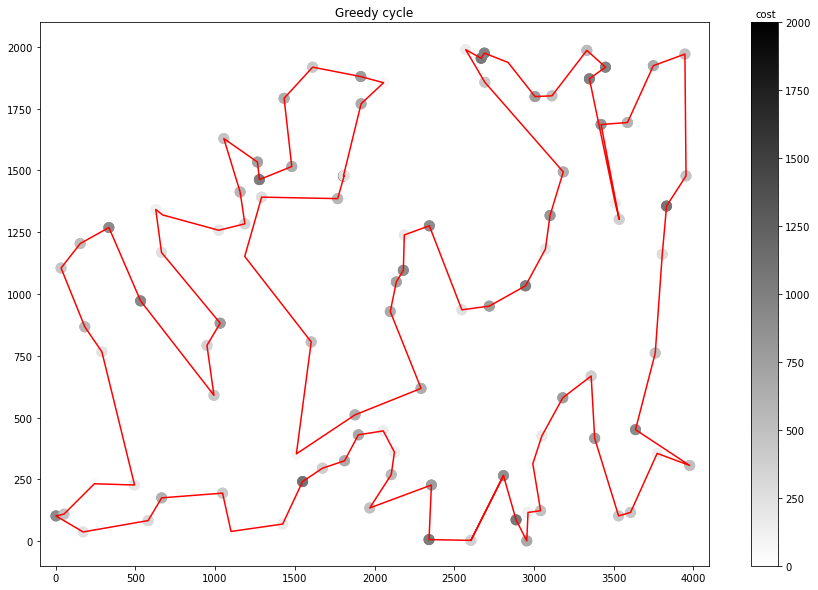

In [64]:
summarize(greedy_cycle, data, 'Greedy cycle')

In [65]:
data = np.loadtxt('TSPB.csv', dtype=int, delimiter=';')

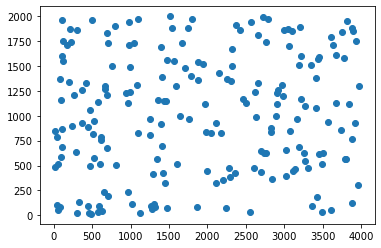

In [66]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

Random solution:
average time: 0.0010468733310699462	worst time: 0.0054988861083984375	best time: 0.0008771419525146484
average score: 269521.92	worst score: 297224	best score: 241313
Best solution:


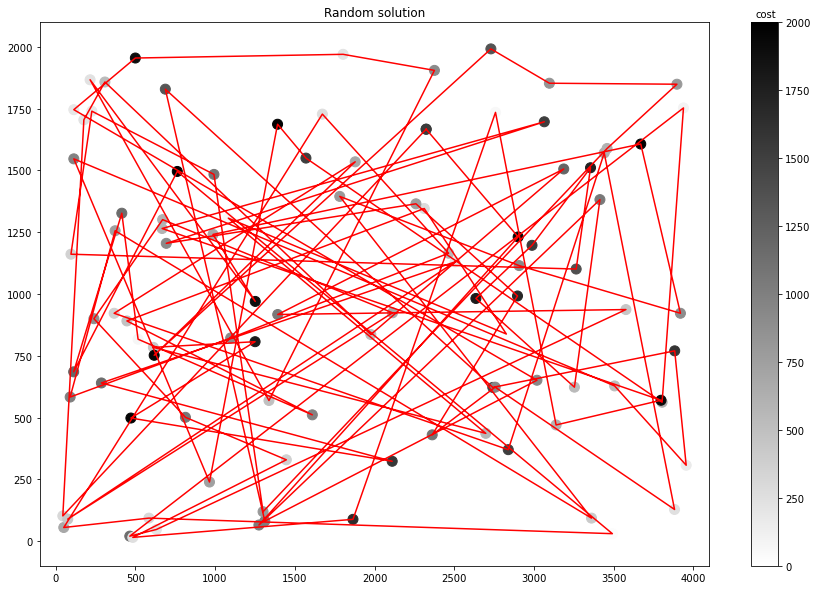

In [67]:
summarize(random_solution, data, 'Random solution')

  0%|          | 0/200 [00:00<?, ?it/s]

Nearest neighbor:
average time: 0.06088043808937073	worst time: 0.10871720314025879	best time: 0.0540921688079834
average score: 80333.3	worst score: 83500	best score: 78548
Best solution:


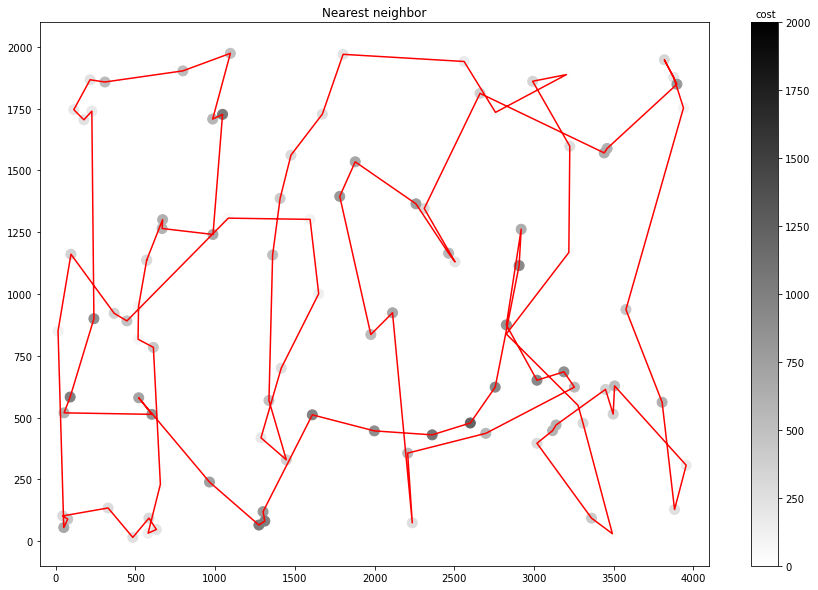

In [68]:
summarize(nearest_neighbor, data, 'Nearest neighbor')

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.23676086068153382	worst time: 0.35024404525756836	best time: 0.20410585403442383
average score: 70734.49	worst score: 76324.0	best score: 68743.0
Best solution:


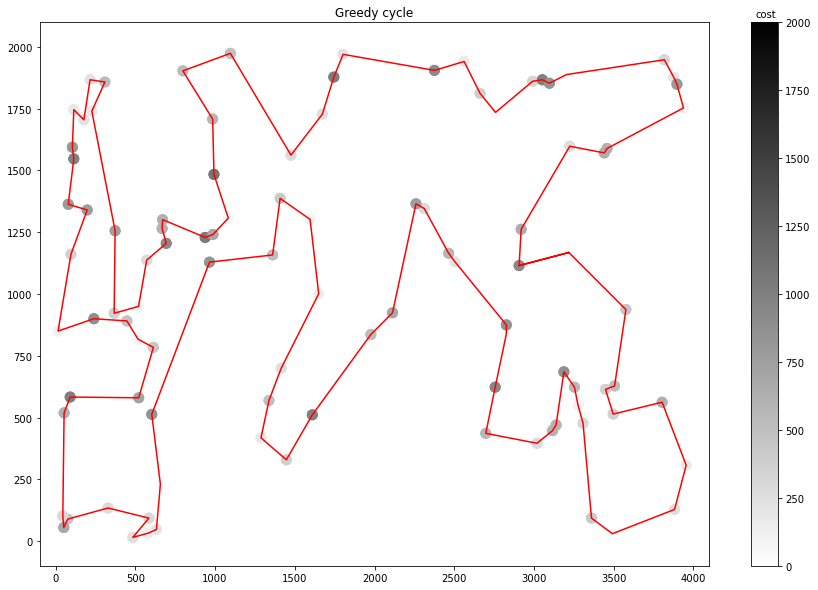

In [69]:
summarize(greedy_cycle, data, 'Greedy cycle')